# Text Generation using a LSTM with the following files:
* Livro do Desassossego
* Os Lusíadas
* Poemas de Álvaro de Campos
* Shakespearean Sonnets

####  The aim of this notebook is to explore the creation of a LSTM model for NLP (Natural Language Processing) and the data treatment on input data sequencies such as text

## Dependencies instalation

In [ ]:
!pip install livelossplot

## Imports

In [ ]:
import joblib
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import string, os
import warnings
import tensorflow as tf
import keras.utils as ku
from tensorflow import keras
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, classification_report
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKerasTF
from nltk.translate.bleu_score import sentence_bleu
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential

tf.random.set_seed(2)
seed(1)

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Notebook Parameters

In [38]:
BATCH_SIZE=250
EPOCHS=100
LEARNING_RATE=0.002
TEST_SIZE=0.25
EVAL_SIZE=0.2
RANDOM_STATE=2023

## Read data file

In [21]:
text=(open("/kaggle/input/livro-do-desassossego-fernando-pessoa/Livro do Desassossego - Fernando Pessoa.txt").read())
print(text[0:100])

Nasci num tempo em que a maioria dos jovens tinham perdido a crença em
Deus, pela mesma razão que os


## Data preparation and cleaning

### Cleaning/formating the text

In [23]:
def clean_text(txt):
    txt = "".join(t for t in txt if t not in string.punctuation).lower()
    txt = txt.replace("\t", " ")
    return txt

text = clean_text(text)
allLines = text.splitlines()
merged_lines = []
for i in range(0, len(allLines), 2):
    if i+1 < len(allLines):
        merged_line = allLines[i] + " " + allLines[i+1]
        merged_lines.append(merged_line)
allLines = merged_lines
print(allLines[0:10])

['nasci num tempo em que a maioria dos jovens tinham perdido a crença em deus pela mesma razão que os seus maiores a tinham tido — sem saber', 'porquê e então porque o espírito humano tende naturalmente para criticar porque sente e não porque pensa a maioria desses jovens escolheu a', 'humanidade para sucedâneo de deus pertenço porém àquela espécie de homens que estão sempre na margem daquilo a que pertencem nem veem só', 'a multidão de que são senão também os grandes espaços que há ao lado por isso nem abandonei deus tão amplamente como eles nem aceitei nunca a', 'humanidade considerei que deus sendo improvável poderia ser podendo pois dever ser adorado mas que a humanidade sendo uma mera ideia', 'biológica e não significando mais que a espécie animal humana não era mais digna de adoração do que qualquer outra espécie animal este culto da', 'humanidade com os seus ritos de liberdade e igualdade pareceume sempre uma revivescência dos cultos antigos em que animais eram como deuses ou', 

### Mapping all the words in to an arbitrary number

In [24]:
tokenizer = Tokenizer()
def get_sequence_of_tokens(allLines):
    tokenizer.fit_on_texts(allLines)
    total_words = len(tokenizer.word_index) + 1
    
    input_sequences = []
    for line in allLines:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(allLines)
print(inp_sequences[:10])

[[816, 72], [816, 72, 100], [816, 72, 100, 18], [816, 72, 100, 18, 1], [816, 72, 100, 18, 1, 3], [816, 72, 100, 18, 1, 3, 566], [816, 72, 100, 18, 1, 3, 566, 22], [816, 72, 100, 18, 1, 3, 566, 22, 817], [816, 72, 100, 18, 1, 3, 566, 22, 817, 567], [816, 72, 100, 18, 1, 3, 566, 22, 817, 567, 440]]


### Padding the data sequences

In [25]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)
print(predictors)

[[   0    0    0 ...    0    0  816]
 [   0    0    0 ...    0  816   72]
 [   0    0    0 ...  816   72  100]
 ...
 [   0    0    0 ...  539    5   74]
 [   0    0    0 ...    5   74 3845]
 [   0    0    0 ...   74 3845    8]]


## LSTM Model

### Building de Model

In [39]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    model.add(Embedding(total_words, 150, input_length=input_len))
    model.add(LSTM(300))
    model.add(Dense(total_words, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(max_sequence_len, total_words)

### Model Summary

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 42, 150)           577050    
                                                                 
 lstm_5 (LSTM)               (None, 300)               541200    
                                                                 
 dense_5 (Dense)             (None, 3847)              1157947   
                                                                 
Total params: 2,276,197
Trainable params: 2,276,197
Non-trainable params: 0
_________________________________________________________________


### Model Training

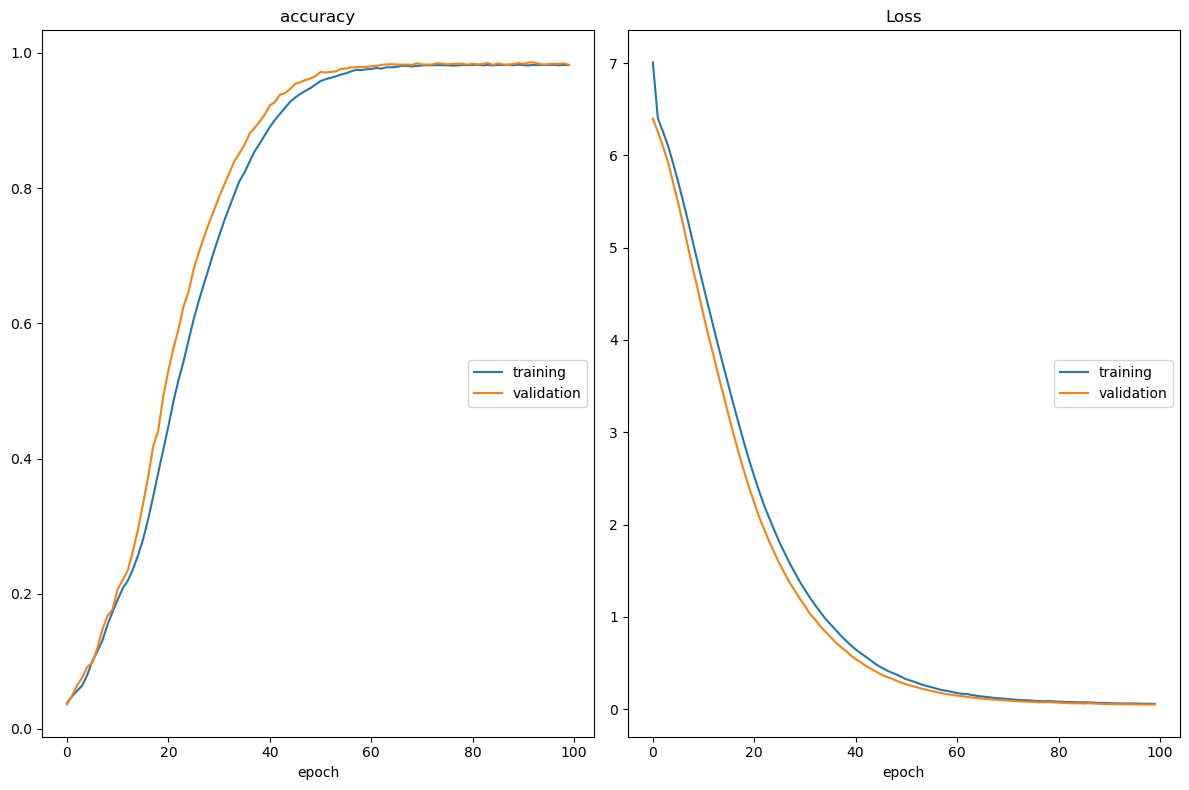

accuracy
	training         	 (min:    0.038, max:    0.982, cur:    0.982)
	validation       	 (min:    0.036, max:    0.986, cur:    0.982)
Loss
	training         	 (min:    0.057, max:    7.007, cur:    0.057)
	validation       	 (min:    0.049, max:    6.399, cur:    0.049)
64/64 [==============================] - 41s 636ms/step - loss: 0.0569 - accuracy: 0.9820 - val_loss: 0.0494 - val_accuracy: 0.9820


In [41]:
predictors_train, predictors_test, label_train, label_test = train_test_split(predictors, label, test_size=TEST_SIZE, random_state=RANDOM_STATE)
history = model.fit(predictors, label, validation_split=EVAL_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(predictors_test, label_test), callbacks=[PlotLossesKerasTF()], verbose=1)

## Model tests

### Generate text

In [55]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list)
        predicted_word_index = np.argmax(predicted, axis=-1)[0]
        output_word = tokenizer.index_word[predicted_word_index]
        seed_text += " " + output_word
    return seed_text.title()


### Tests

In [59]:
result = generate_text("nasci num tempo em que", 98, model, max_sequence_len)
print(result)

1/1 [==============================] - 0s 31ms/step
Nasci Num Tempo Em Que A Maioria Dos Jovens Tinham Perdido A Crença Em Deus Pela Mesma Razão Que Os Seus Maiores A Tinham Tido — Sem Saber Que Por Mau Que Me Prende O Rosto Muscular Com Que Ele Disse O Que Me Não Lembra Ou A Inclinação De Ouvir Com Os Olhos Com Que Recebeu A Narrativa Que Me Não Foram Advindos Ou Dos Triunfos Que Não Sei Quais São As Palavras Humanas Com Que Possa Definilo Não Sei Se Estou Com Febre Como Sinto Se Foi Embora E Não Era Mais Digna De Adoração Do Que Qualquer Outra Espécie Animal


## Model Save

In [62]:
joblib.dump(model, 'lstmtextgeneration.pkl')

['lstmtextgeneration.pkl']